### 1. Dependencies

In [ ]:
 pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 12.9MB/s 


In [ ]:
import numpy as np
import tempfile
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


### 2. Divide training set and validation set
Information about the data, such as image size, can be found on Colab's documentation.

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(type(train_ds))
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


#### See if images are loaded properly.

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


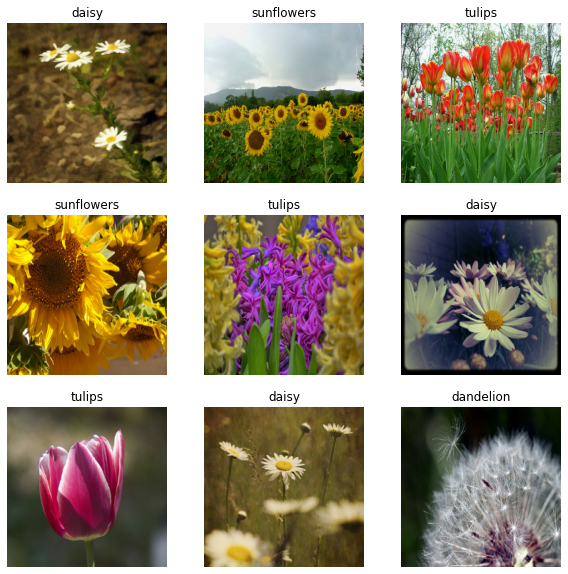

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Autotune for better performance.
Refer to Colab's documentation for more information.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds2 = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds.prefetch(buffer_size=AUTOTUNE)

autotune= -1


#### Data augmentation for better performance.

In [ ]:
num_classes = 5
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/4",
                   trainable=False),  
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([64, 224, 224, 3])  # Batch input shape.

#### Check if batchs are loaded properly.

In [ ]:
#check output shape
image_batch, label_batch = next(iter(train_ds2))
#label_batch [64,], ints
#image_batch [64, 5] floats
feature_batch = m(image_batch)
print(feature_batch.shape)
print(feature_batch)

In [ ]:
print(label_batch)

tf.Tensor([3 3 4 4 1 3 4 3 4 4 1 3 0 0 2 4 1 3 1 1 1 3 1 2 1 3 4 1 4 4 4 3], shape=(32,), dtype=int32)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = rescale(x)
outputs = m(x)
model = tf.keras.Model(inputs, outputs)

### Training


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds2,
                    epochs=30,
                    validation_data=val_ds2)
keras_file = "m_30epo.h5"
keras.models.save_model(model, keras_file)

Epoch 1/30
46/46 [==============================] - 31s 395ms/step - loss: 2.0946 - accuracy: 0.2433 - val_loss: 1.2552 - val_accuracy: 0.5354
Epoch 2/30
46/46 [==============================] - 17s 351ms/step - loss: 1.2461 - accuracy: 0.5165 - val_loss: 0.8979 - val_accuracy: 0.6989
Epoch 3/30
46/46 [==============================] - 17s 353ms/step - loss: 0.9494 - accuracy: 0.6527 - val_loss: 0.7323 - val_accuracy: 0.7629
Epoch 4/30
46/46 [==============================] - 18s 360ms/step - loss: 0.7978 - accuracy: 0.7160 - val_loss: 0.6360 - val_accuracy: 0.7888
Epoch 5/30
46/46 [==============================] - 18s 359ms/step - loss: 0.6846 - accuracy: 0.7561 - val_loss: 0.5735 - val_accuracy: 0.8038
Epoch 6/30
46/46 [==============================] - 18s 363ms/step - loss: 0.6505 - accuracy: 0.7738 - val_loss: 0.5269 - val_accuracy: 0.8147
Epoch 7/30
46/46 [==============================] - 18s 364ms/step - loss: 0.5886 - accuracy: 0.7939 - val_loss: 0.4932 - val_accuracy: 0.8229

#### save tflite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

# Save the unquantized/float model:
tflite_models_dir = pathlib.Path("/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"30epo.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi1fpo9yb/assets


INFO:tensorflow:Assets written to: /tmp/tmpi1fpo9yb/assets


170043220

### Post-training quantization

step 1: convert without it: a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.
with it: quantize all fixed parameters, but other variable data is still in float format, line2 fixes it

step 2: float fall back quantization
provide a large-enough subset of input, RepresentativeDataset, to allow the converter to estimate a dynamic range for all the variable data.
After step 2, all variables and weights are int 8 but inputs and outputs are not.

step 3:
convert inputs and outputs to int 8

In [ ]:
def representative_data_gen():
  for input_value, _ in train_ds.take(2):
    # Model has only one input so each data point has one element.
    yield [input_value]
# convert keras file to tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#1
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#2
converter.representative_dataset = representative_data_gen
#3
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpw2wf2tzt/assets


INFO:tensorflow:Assets written to: /tmp/tmpw2wf2tzt/assets


#### Check output size
should output 2 and 
(64, 224, 224, 3)

In [ ]:
print(tf.data.experimental.cardinality(train_ds.take(2)).numpy())
x = 0
for y, _ in train_ds.take(1):
  print(y.shape)
  x += 1

2
(64, 224, 224, 3)
1


In [ ]:
#make sure I/O is int 8
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


#### Save the quantized model.

In [ ]:
tflite_model_quant_file = tflite_models_dir/"30epo_q.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

44547624

### Run tflite model
The "30epo_q.tflite" is the "flower_30epo_q.tflite" in the github repository. Make sure you have a labels.txt that has the classes. "flower_labels.txt" is also available in the github repo.<br>
This is post training integer quantization, refer to https://www.tensorflow.org/lite/performance/post_training_integer_quant
for more information.

In [ ]:
default_model_dir = tflite_models_dir
default_model = '30epo_q.tflite' 
default_labels = 'flower_labels.txt'
with open(args.labels, 'r') as f:
        pairs = (l.strip().split(maxsplit=1) for l in f.readlines())
        labels = dict((int(k), v) for k, v in pairs)


In [ ]:
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [ ]:
import matplotlib.pylab as plt

# Can change this to test a different image
test_image_index = 1
true = 
## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = " Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Performance visualization


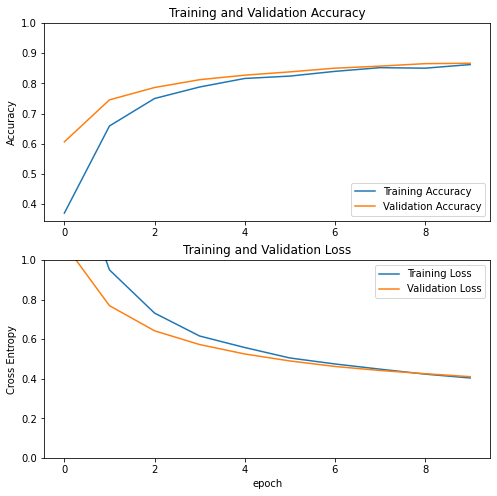

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()